# Validation 
We will validate the model with a seperate dataset


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json 
import h5py

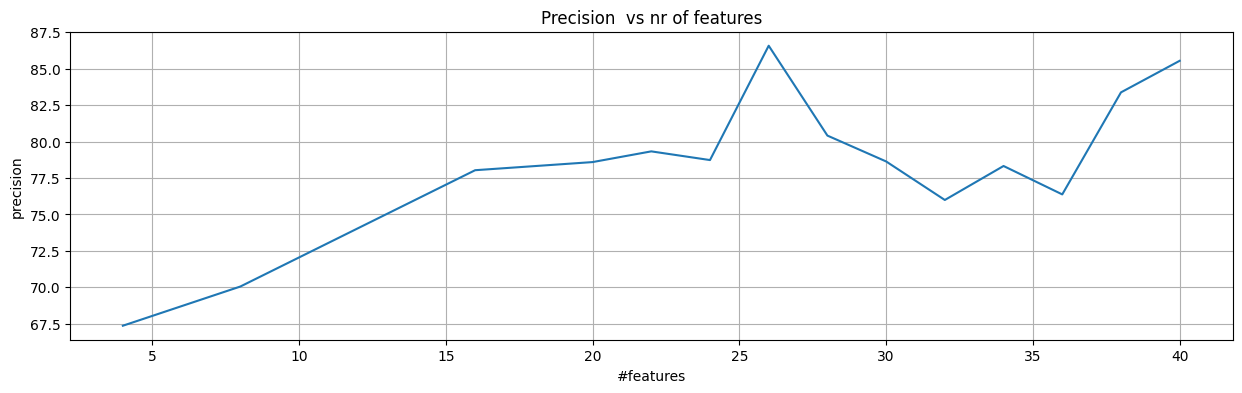

In [2]:
def load_info(size):
    with open(f'../Results/ADSB_Validation/ADSB_{size}/Results/info', "r") as outfile:
        info =  json.load(outfile)
    return info

sizes = [4,8,16,20,22,24,26,28,30,32,34,36,38,40]

acc = [load_info(s)['acc']*100 for s in sizes ]

plt.figure(figsize=(15, 4))
plt.plot(sizes,acc)
plt.title('Precision  vs nr of features')
plt.xlabel('#features')
plt.ylabel('precision')
plt.grid(True)
plt.show()

In [76]:
class Result:
    def __init__(self,size) -> None:
        self.size=size
        with open(f'../Results/ADSB_Validation/ADSB_{size}/Results/info', "r") as outfile:
            info =  json.load(outfile)
        self.acc = info['acc']
        self.th = info['th']
        data = np.load(f'../Results/ADSB_Validation/ADSB_{size}/Results/final.npy',allow_pickle=True).item()

        self.anchors = data['anchor']
        self.test = data['test']
        self.loss = data['Loss']
        self.corr = data['Corr']
        self.flag = data['f']
        self.n_min = np.min(self.anchors,axis=0)
        self.n_range = np.max(self.anchors,axis=0)-self.n_min
    
    def calculate_distance(self,a,b):
        return np.sum((a - b) ** 2,axis=1)
    
    def transmit_features(self,a,bits):
        ## normalise features
        a_n = (a-self.n_min)/self.n_range
        ## Quantize 
        a_nq = self.quantize(a_n,bits)
        ## Denormalize features
        a_nqd = a_nq*self.n_range+self.n_min

        return a_nqd
    
    def calculate_accuracy(self,nr_bits=32, uniform=True):
        if uniform:
            bits = [nr_bits]*self.size
        else:
            bits= self.get_optimal_bits_pca(nr_bits)
            print(nr_bits,bits)

        anchors = self.transmit_features(self.anchors,bits)
        test = self.transmit_features(self.test,bits)

        idx_pos = self.flag==1
        idx_neg = self.flag==0

        pos = self.calculate_distance(anchors[idx_pos],test[idx_pos])
        neg = self.calculate_distance(anchors[idx_neg],test[idx_neg])

        p = pos<self.th 
        n = neg<self.th
        pn=np.sum(p)/(np.sum(n)+np.sum(p))
        # pn=1-np.sum(n)/np.sum(idx_neg)
        return pn*100
    
    def calculate_recall(self,nr_bits=32, uniform=True):
        # things that were a hit before quantisation, should still be a hit
        if uniform:
            bits = [nr_bits]*self.size
        else:
            bits= self.get_optimal_bits_pca2(nr_bits)
            print(nr_bits,bits)

        anchors = self.transmit_features(self.anchors,bits)
        test = self.transmit_features(self.test,bits)

        loss_org = self.calculate_distance(self.anchors,self.test)
        loss_quant = self.calculate_distance(anchors,test)

        org = loss_org<self.th
        quant = loss_quant<self.th
        res = org==quant

        return np.mean(res)
    
    def quantize_column(self,a,nr_bits):
        if nr_bits==0:
            return a*0
        levels = 2 ** nr_bits
        return np.round(a * (levels - 1))/(levels - 1)
    
    def quantize(self,a,nr_bits):
        assert len(nr_bits)==len(a[0])
        res = np.zeros_like(a)
        for i,n in enumerate(nr_bits):
            res[:,i] = self.quantize_column(a[:,i],n)
        return res 
    
    def get_optimal_bits_pca(self,avg_bits):
        # fill sequentially as there is a maximum
        val,feature = self.pca()

        bits = np.zeros_like(feature) +1# each feature at least 1 bit?
        total_bits = avg_bits*self.size
        leftover_bits = total_bits

        carry = 0
        for v,f in zip(val,feature):
            proposed_bits = np.ceil(total_bits*v)+carry
            if proposed_bits>32:
                carry = proposed_bits-32
                proposed_bits = 32
            else:
                carry=0
            if proposed_bits>leftover_bits:
                proposed_bits=leftover_bits
            bits[f]=proposed_bits
            leftover_bits-=proposed_bits
        return bits
    

    def get_optimal_bits_pca2(self,avg_bits):
        # fill sequentially as there is a maximum
        val,feature = self.pca()

        val = np.arange(len(feature)+1,1,-1)
        val=val/np.sum(val)
        bit_min = 8
        bits = np.zeros_like(feature) +bit_min# each feature at least 1 bit?
        total_bits = avg_bits-len(feature)*bit_min
        leftover_bits = total_bits

        carry = 0
        for v,f in zip(val,feature):
            proposed_bits = np.ceil(total_bits*v)+carry
            if proposed_bits>32-bit_min:
                carry = proposed_bits-32-bit_min
                proposed_bits = 32-bit_min
            else:
                carry=0
            if proposed_bits>leftover_bits:
                proposed_bits=leftover_bits
            bits[f]+=proposed_bits
            leftover_bits-=proposed_bits
        return bits
    
    def get_bits_variane(self,nr_bits):
        # Step 2: Compute the variance for each feature
        feature_variances = np.var(self.anchors, axis=0)
        percentages = feature_variances/np.sum(feature_variances)

        # # Step 3: Total number of bits to distribute
        total_bits = self.size*nr_bits
        leftover_bits = total_bits
        sort = np.argsort(percentages)[::-1]

        bits = np.zeros_like(feature_variances)+1

        carry = 0
        for v,f in zip(percentages,sort):
            proposed_bits = np.ceil(total_bits*v)+carry
            if proposed_bits>31:
                carry = proposed_bits-31
                proposed_bits = 31
            else:
                carry=0
            if proposed_bits>leftover_bits:
                proposed_bits=leftover_bits
            bits[f]=proposed_bits
            leftover_bits-=proposed_bits
        return bits


    def pca(self):
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        # Example data: rows are samples, columns are features
        data = self.anchors
        # 1. Standardize the data
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(data)
        # 2. Perform PCA
        pca = PCA(n_components=data.shape[1])  # Keep all components
        pca.fit(standardized_data)
        # 3. Calculate feature contributions
        explained_variance_ratio = pca.explained_variance_ratio_
        components = pca.components_
        # Calculate contribution of each feature to the variance
        feature_contributions = np.sum(np.abs(components.T) * explained_variance_ratio, axis=1)
        # Rank features
        feature_ranking = np.argsort(feature_contributions)[::-1]  # Sort in descending order
        feature_ranking = np.argsort(feature_contributions) # Sort in descending order
        return pca.explained_variance_ratio_,feature_ranking
    

    def plot_pca(self):
        val,feature = self.pca()
        plt.figure(figsize = (10, 5))
        # creating the bar plot
        plt.bar(feature, val*100, 
                width = 0.7)

        plt.xlabel("Feature nr")
        plt.ylabel("percentage")
        plt.title("PCA analysis")
        plt.grid()

        plt.show()
    

In [74]:
r= Result(26)
bits = 5*26+10
print(r.get_optimal_bits_pca(bits))
print(r.get_optimal_bits_pca2(bits))

[32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32]
[6 5 6 6 6 5 6 6 5 5 5 6 6 5 5 5 5 6 5 5 5 5 5 5 5 6]


208 [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
209 [8 8 8 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
210 [8 8 8 9 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
211 [8 8 8 9 9 8 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
212 [8 8 9 9 9 8 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
213 [9 8 9 9 9 8 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
214 [9 8 9 9 9 8 9 8 8 8 8 8 9 8 8 8 8 8 8 8 8 8 8 8 8 8]
215 [9 8 9 9 9 8 9 9 8 8 8 8 9 8 8 8 8 8 8 8 8 8 8 8 8 8]
216 [9 8 9 9 9 8 9 9 8 8 8 8 9 8 8 8 8 9 8 8 8 8 8 8 8 8]
217 [9 8 9 9 9 8 9 9 8 8 8 9 9 8 8 8 8 9 8 8 8 8 8 8 8 8]
218 [9 8 9 9 9 8 9 9 8 8 8 9 9 8 8 8 8 9 8 8 8 8 8 8 8 9]
219 [9 8 9 9 9 8 9 9 8 8 8 9 9 8 8 8 8 9 8 8 8 9 8 8 8 9]
220 [9 8 9 9 9 8 9 9 8 8 8 9 9 8 9 8 8 9 8 8 8 9 8 8 8 9]
221 [9 8 9 9 9 8 9 9 8 8 8 9 9 9 9 8 8 9 8 8 8 9 8 8 8 9]
222 [ 9  8  9 10  9  8  9  9  8  8  8  9  9  9  9  8  8  9  8  8  8  9  8  8
  8  9]
223 [ 9  8  9 10 10  8  9  9  8  8  8  9  9  9  9  8  8  9  8  8  8  9  8  8
  8  9]
224 [ 9  8 10 10 1

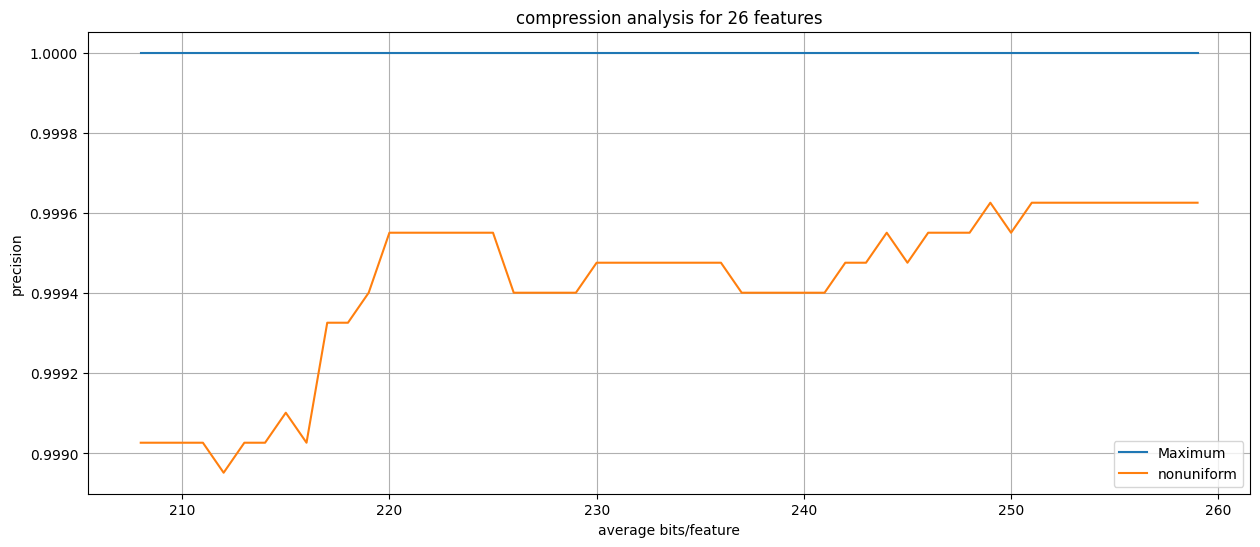

In [77]:
# What is the percentage of data that is estimated differently now. 
# recall == different result 
s = 26
r = Result(s)
# r.plot_pca()
bits = range(26*8,26*10)
plt.figure(figsize=(15,6))
plt.plot(bits,[r.calculate_recall(nr_bits=64) for b in bits],label='Maximum')
# plt.plot(bits,[r.calculate_recall(nr_bits=b) for b in bits],label='uniform')
plt.plot(bits,[r.calculate_recall(nr_bits=b,uniform=False) for b in bits],label='nonuniform')
plt.grid()
plt.xlabel('average bits/feature')
plt.ylabel('precision')
plt.legend()
plt.title(f'compression analysis for {s} features')
plt.show()

# s = 26
# r = Result(s)
# bits = range(33)
# plt.figure(figsize=(15,6))
# plt.plot(bits,[r.calculate_accuracy(nr_bits=64) for b in bits],label='Maximum')
# plt.plot(bits,[r.calculate_accuracy(nr_bits=b) for b in bits],label='uniform')
# plt.plot(bits,[r.calculate_accuracy(nr_bits=b,uniform=False) for b in bits],label='nonuniform')
# plt.grid()
# plt.xlabel('average bits/feature')
# plt.ylabel('Precision')
# plt.legend()
# plt.title(f'compression analysis for {s} features')
# plt.show()


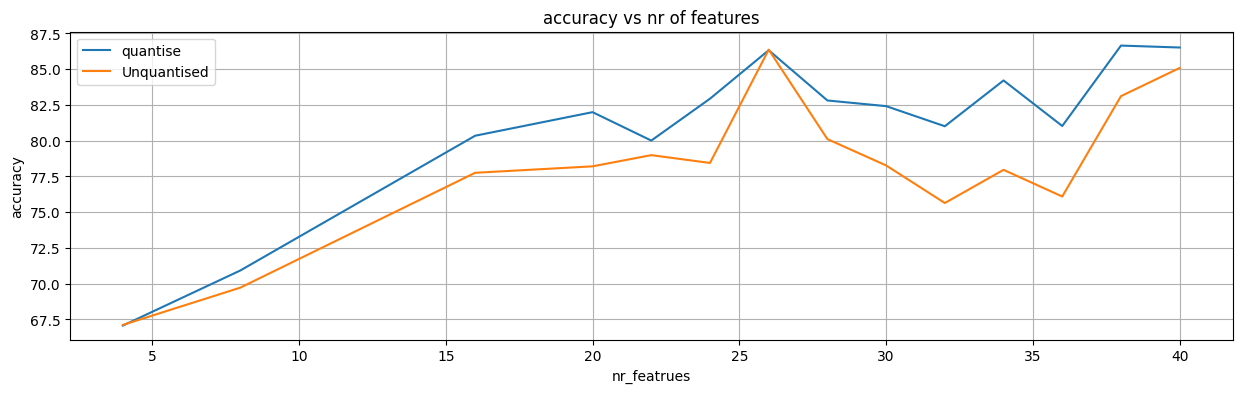

In [98]:



acc = []
acc_orf = []
sizes= [4,8,16,20,22,24,26,28,30,32,34,36,38,40]
for s in sizes:
    r = Result(s)
    acc_orf.append(r.calculate_accuracy(nr_bits=32))
    acc.append(r.calculate_accuracy(nr_bits=4))


plt.figure(figsize=(15, 4))
plt.plot(sizes,acc,label='quantise')
plt.plot(sizes,acc_orf,label='Unquantised')
plt.title('accuracy vs nr of features')
plt.xlabel('nr_featrues')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.show()



In [9]:

# Example data (rows = samples, columns = features)
r = Result(4)

print(r.get_bits_variane(25))



[18. 32. 32. 18.]


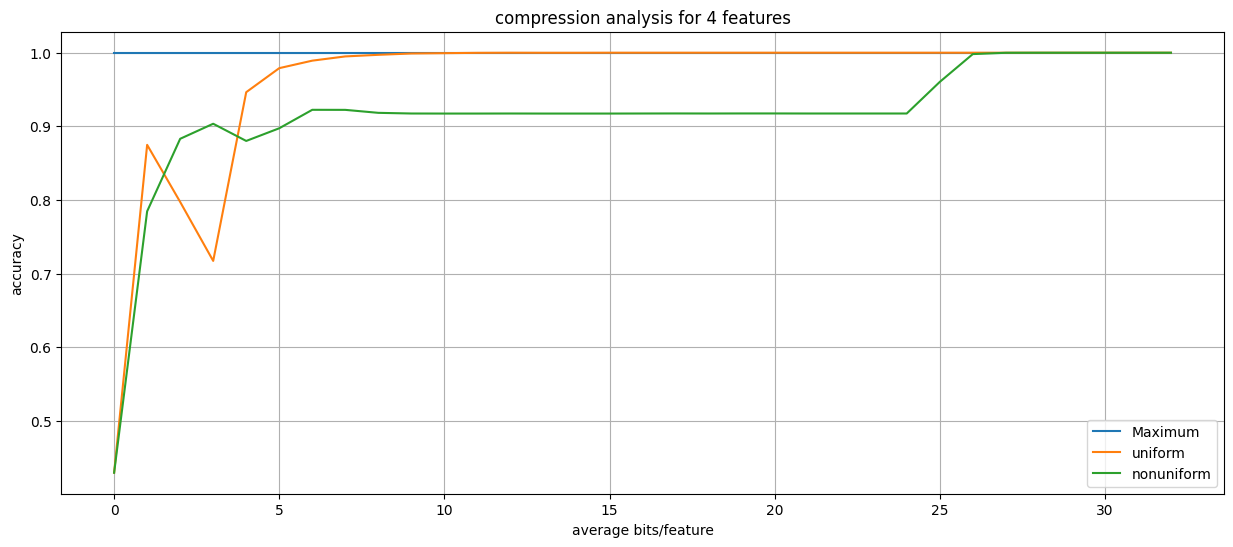

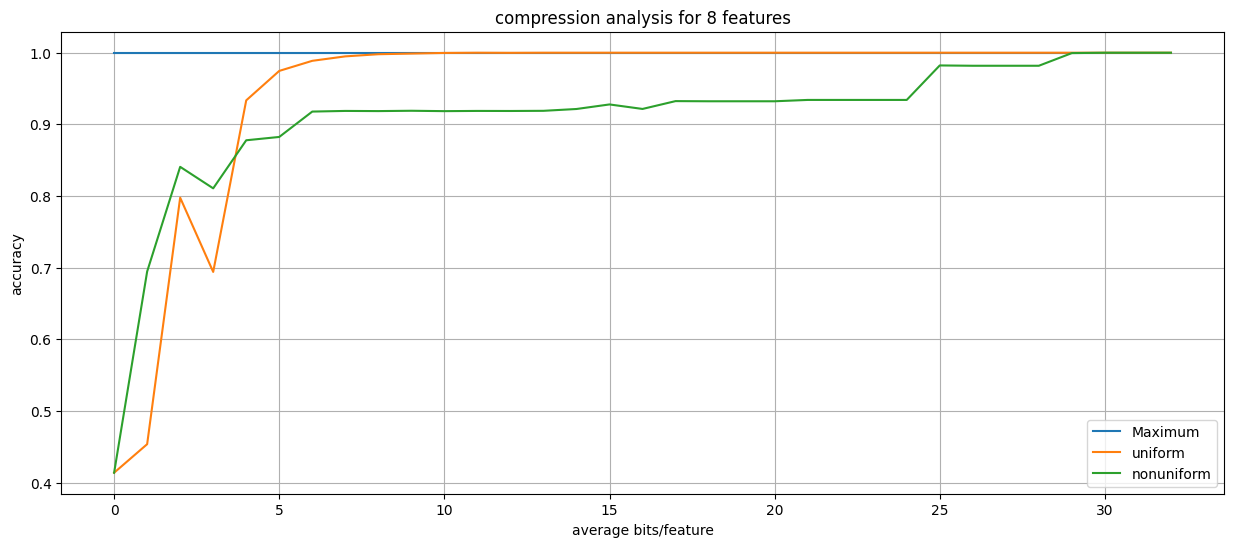

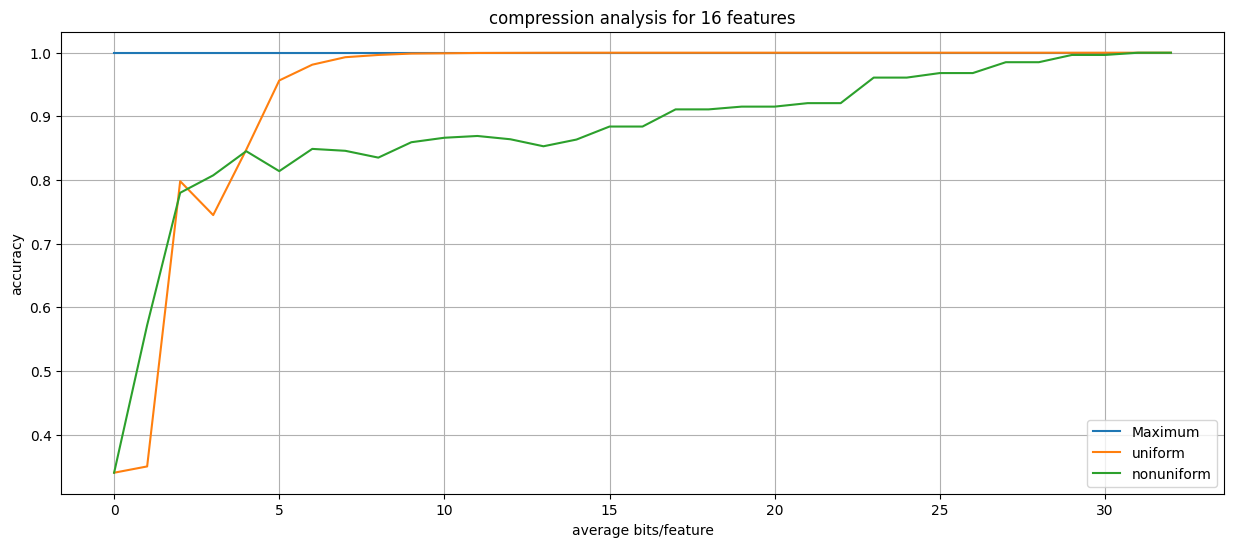

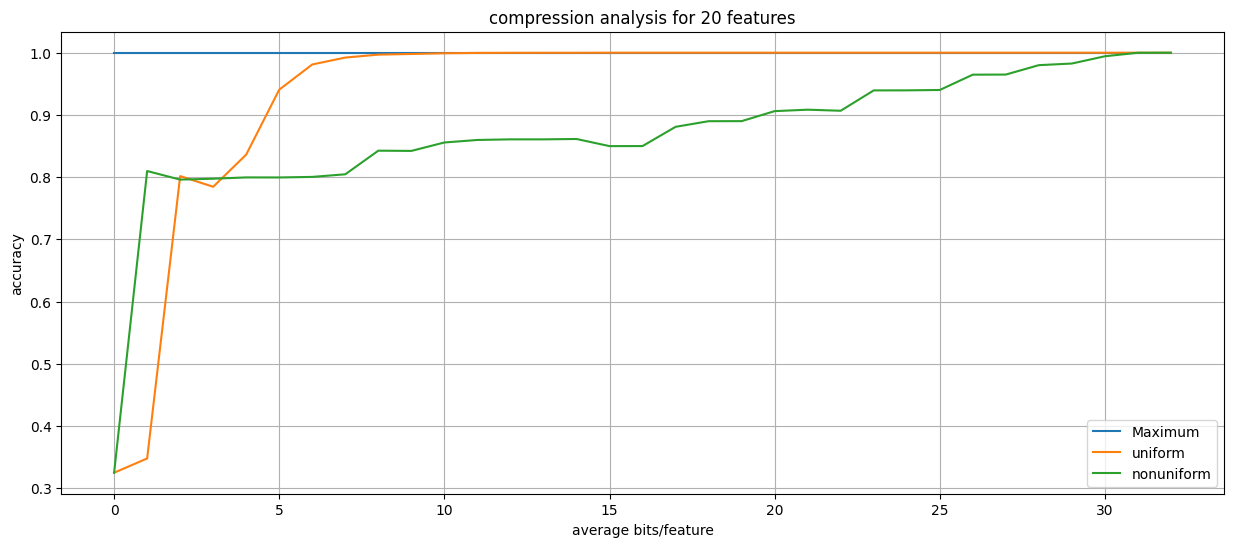

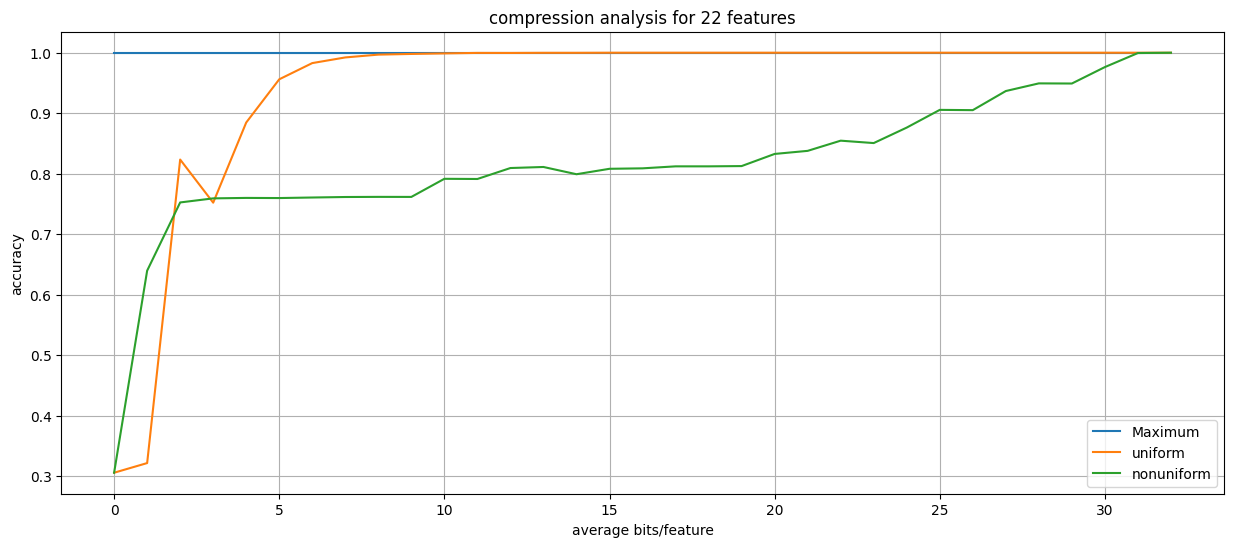

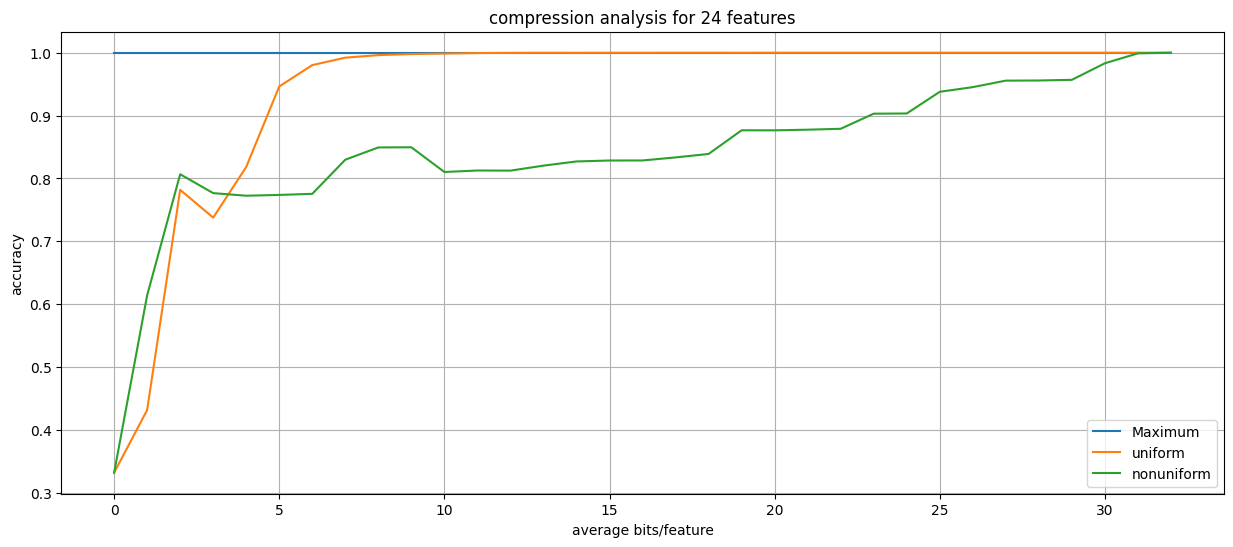

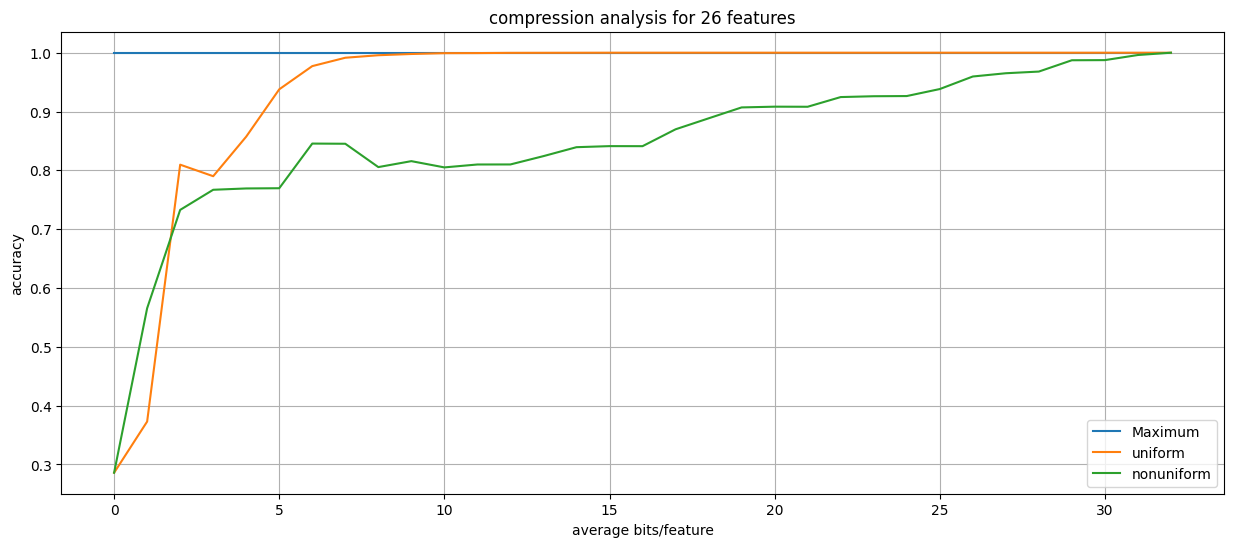

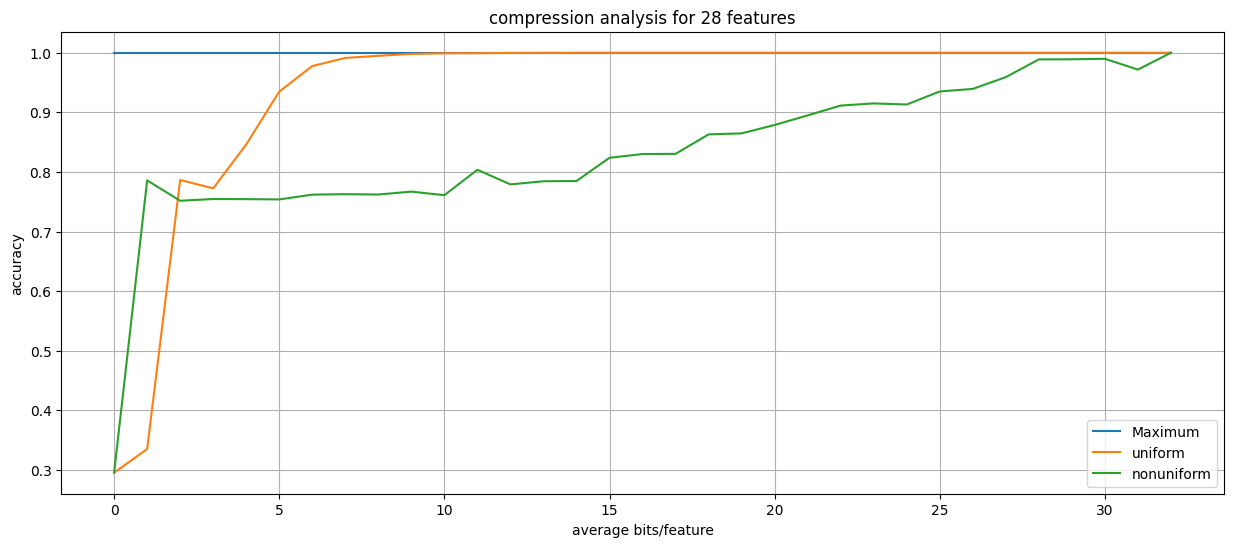

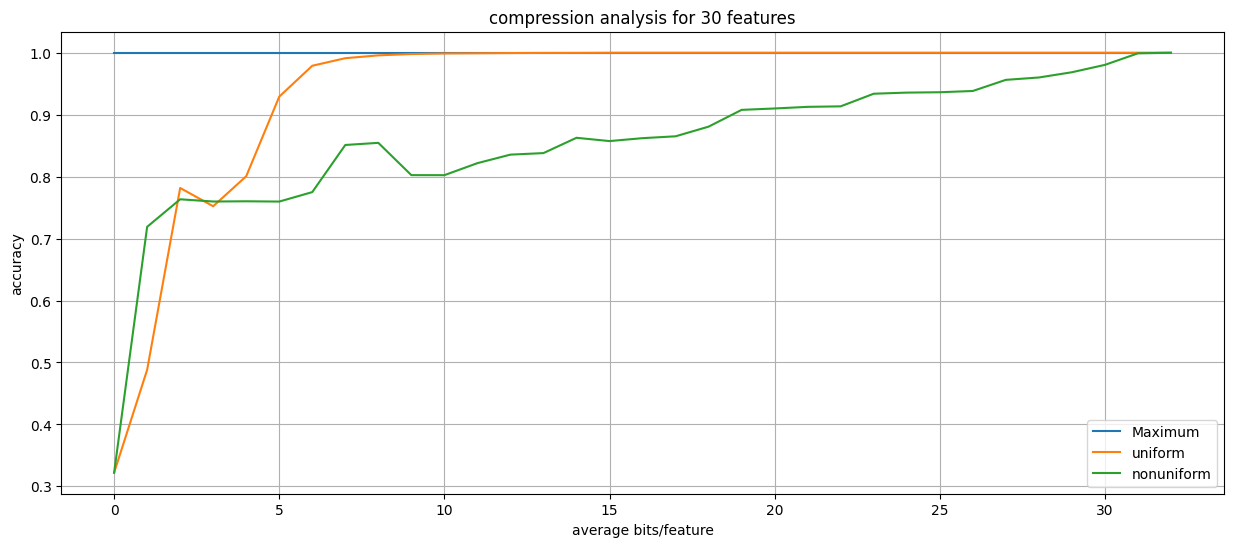

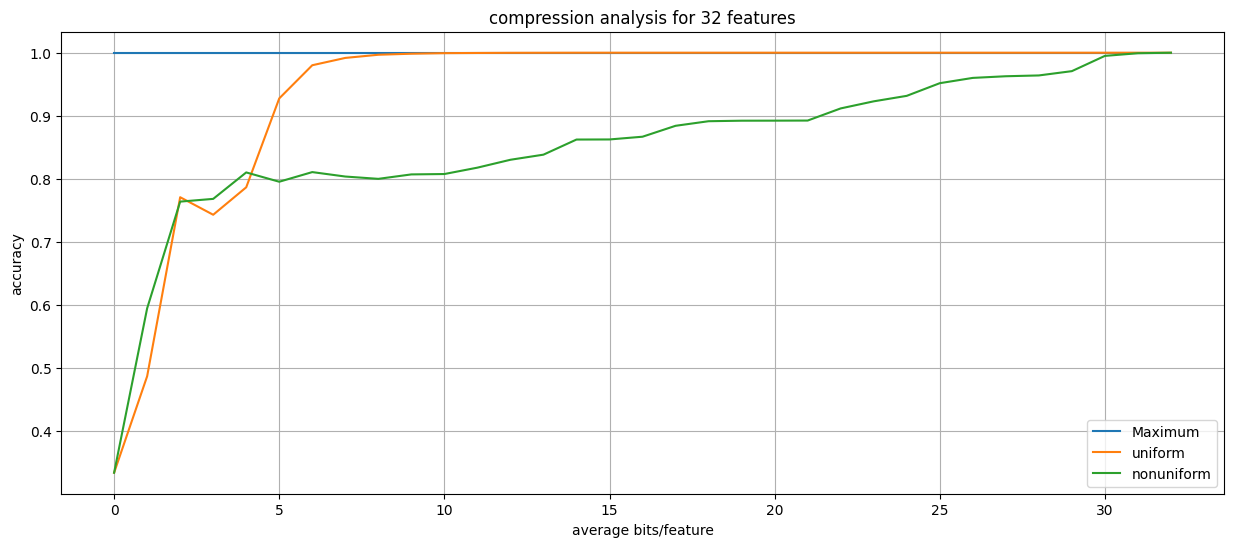

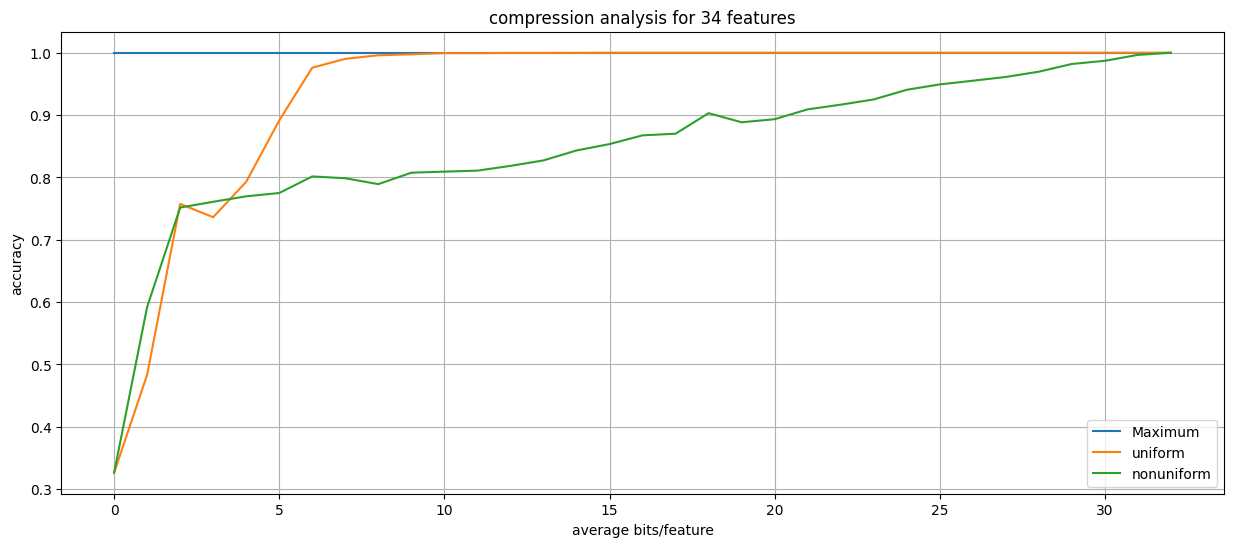

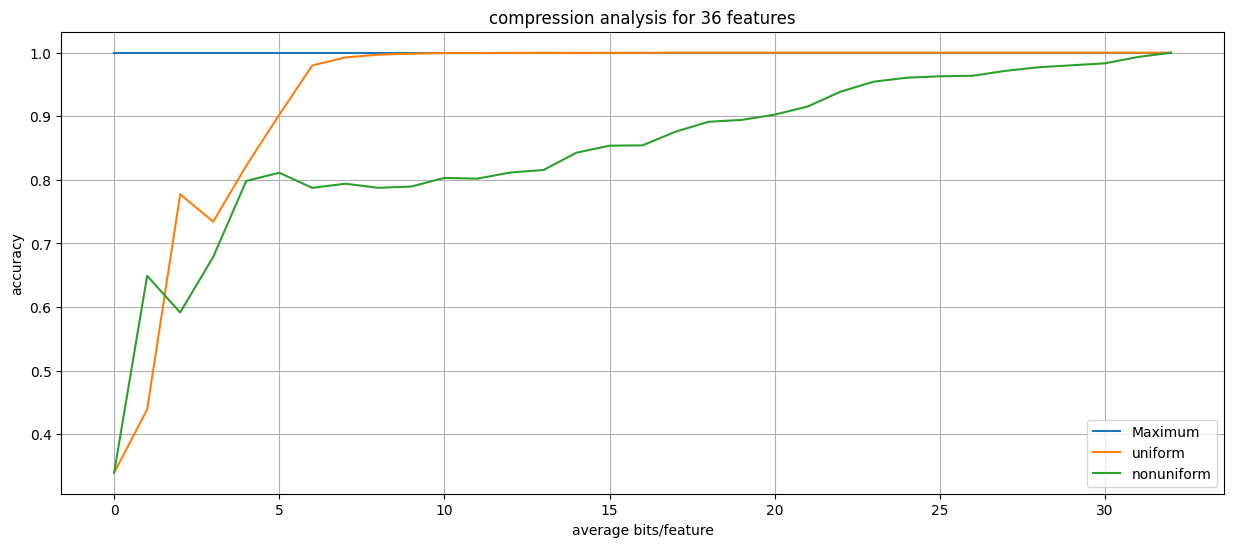

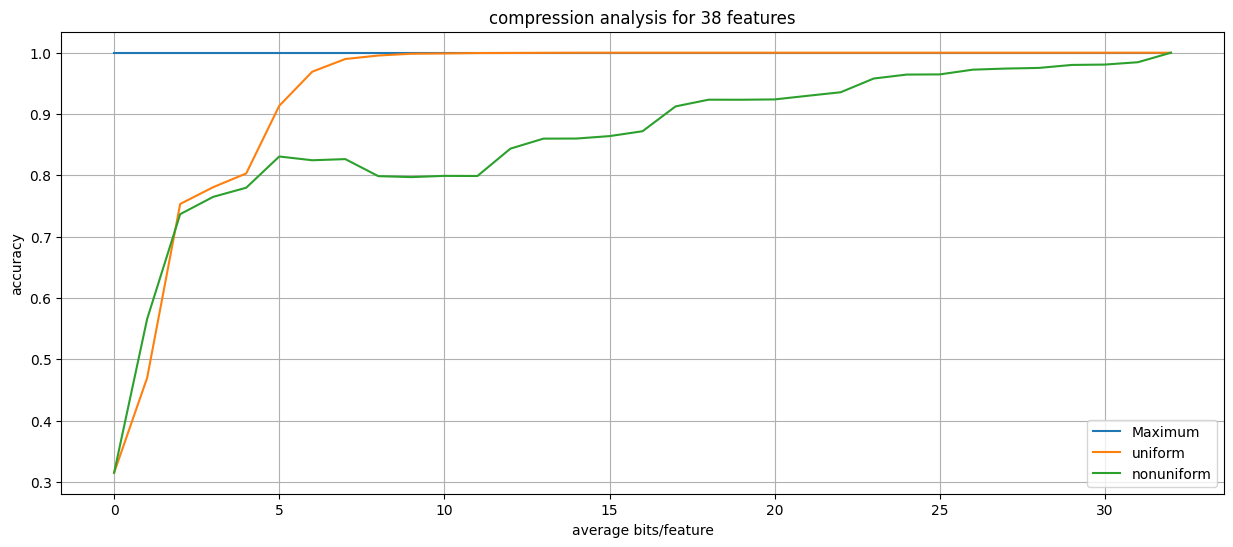

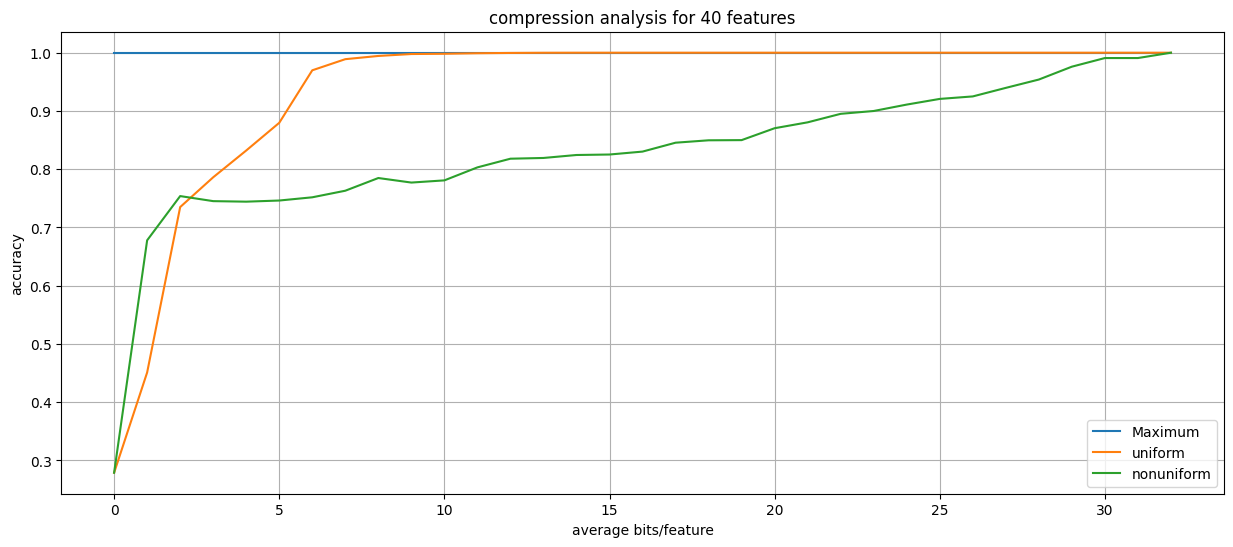

In [124]:
for s in sizes:
    r = Result(s)
    bits = range(33)
    plt.figure(figsize=(15,6))
    plt.plot(bits,[r.calculate_recall(nr_bits=64) for b in bits],label='Maximum')
    plt.plot(bits,[r.calculate_recall(nr_bits=b) for b in bits],label='uniform')
    plt.plot(bits,[r.calculate_recall(nr_bits=b,uniform=False) for b in bits],label='nonuniform')
    plt.grid()
    plt.xlabel('average bits/feature')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title(f'compression analysis for {s} features')
    plt.show()